# Importing Basic Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
print(tf.__version__)
%matplotlib inline
plt.style.use('default')

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

2.13.0
GPU available (YESSSS!!!!!)


# Getting with Data

In [ ]:
import os
import xml.etree.ElementTree as ET
import random
import itertools

# read annotations from the xml file
def read_annotations(xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):

        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

In [ ]:
# read images form the files
from PIL import Image, ImageDraw

# This function reads the images from the files
def read_data(file_names):
    # Initialize two empty lists
    data = []
    dims = []

    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:

        # Get the paths to the files
        img_path = os.path.join(data_dir, 'JPEGImages', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Annotations', 'Horizontal Bounding Boxes',file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Exclude 4-channel images
        if (np.array(img).shape[2]) != 3:
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append(width)
            dims.append(height)

        data.append((img, annotations))


    return data, dims

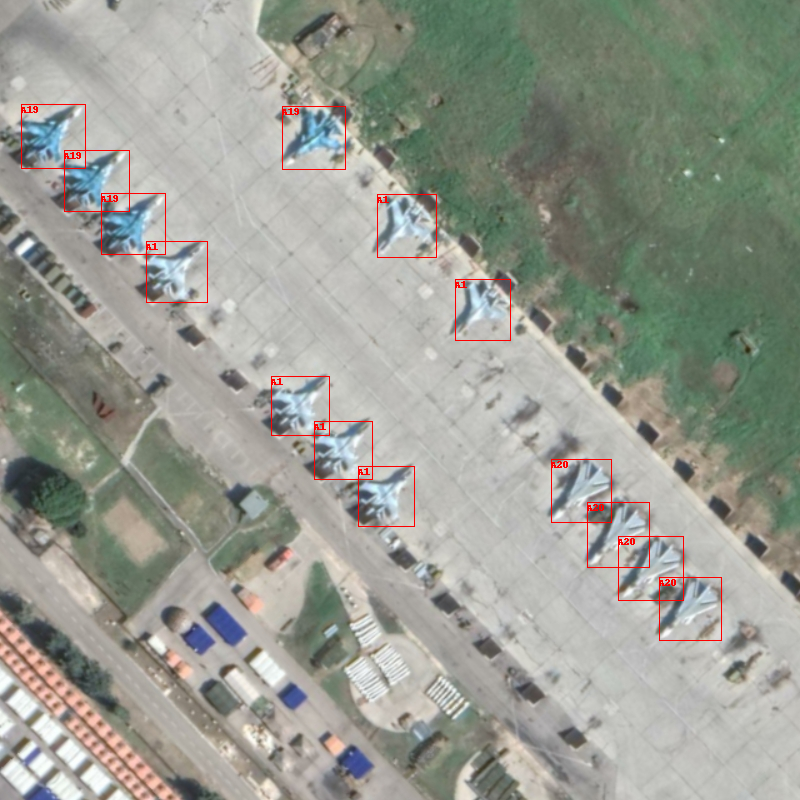

In [ ]:
# defining directory and checking

data_dir = "/content/drive/MyDrive/Datasets/Satellite_Millitary"

# Read the train and test filenames from the ImageSets/Main folder
with open(os.path.join(data_dir, 'ImageSets/Main/train.txt'), 'r') as f:
    train_filenames = f.read().splitlines()
train_data, train_obj_dims = read_data(train_filenames)


# Display an exmple
img = train_data[0][0]
draw = ImageDraw.Draw(img)
objects = train_data[0][1]
for obj in objects:
    draw.rectangle(obj[1], outline='red')
    draw.text((obj[1][0], obj[1][1]), obj[0], fill='red')
img

# Preprocesssing Image


In [ ]:
# transforming image
def pad_img(img):
    # Get the dimensions the image
    old_size = img.size
    desired_size = (64,64)
    max_dim = max(old_size)
    padded = Image.new("RGB", (max_dim, max_dim))
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2
    padded.paste(img, (x, y))
    out_img = padded.resize(desired_size)
    return out_img

In [ ]:
# extracting objects from xml file
def extract_obj(img, annotations):
    objects = []
    labels = []
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)
        objects.append(roi)
    labels = np.array(labels)
    return objects, labels

## X_train , Y_train

In [ ]:
def preprocessing(data):

    # Define two temporary lists to store objects and labels
    X_temp = []
    y_temp = []

    # Iterate over images and annotations to prepare X_train and y_train
    for img, annotations in data:

        # Extract the objects from current image
        objects, labels = extract_obj(img, annotations)

        # Pad objects
        padded = []
        for obj in objects:
            padded_img = pad_img(obj)
            padded.append(padded_img)

        # Add the objects to two temporary lists
        X_temp.append(padded)
        y_temp.append(labels)

    # Flatten the list of labels and convert to numpy array
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)

    # Encode the labels
    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()

    n_channels = 3

    X_list = []

    # Normalize and create a list of image arrays
    for img in X_temp:
        for obj in img:
            X_list.append(np.array(obj)/255.0)

    # Convert the list of images to an array
    X = np.array(X_list)

    return X, y, orig_labels_np


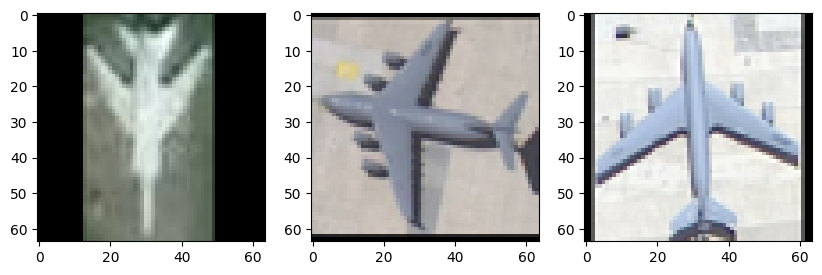

In [ ]:
# Get features and labels
X, y, orig_labels = preprocessing(train_data)
n_labels = y.shape[1]

# Display some of the padded objects
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(X[np.argmin(train_obj_dims)//2], cmap='gray')
ax1.imshow(X[30], cmap='gray')
ax2.imshow(X[np.argmax(train_obj_dims)//2], cmap='gray')

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(
                                                      X,
                                                      y,
                                                      test_size = 0.2,
                                                      random_state = 42,
                                                      )

X_train.shape, y_train.shape , X_test.shape , y_test.shape

((6249, 64, 64, 3), (6249, 20), (1563, 64, 64, 3), (1563, 20))

# Modelling

## Helper Functions

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Creating a function which stores the best epoch model with specific name to used later
import os

def create_model_checkpoint(model_name , save_path = "/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path , model_name),
                                            verbose = 1,
                                            save_best_only= True,
                                            )

In [ ]:
n_labels

20

# Resnet*3

In [ ]:
Resnetx3_Url = "https://tfhub.dev/google/bit/m-r50x3/1"

In [ ]:
# Create model function to create a model from url
import tensorflow_hub as hub
IMAGE_SHAPE = (64,64)

def create_model(model_url , num_classes = 20):
  feature_extractor_layer = hub.KerasLayer(model_url , trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))

 # create model with feature extractor layer and last layer with dense layer
  model_resnetx3 = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes , activation = "softmax" , name = "output_layer")
  ])

  return model_resnetx3

In [ ]:
# Create model
resnetx3_model = create_model(model_url=Resnetx3_Url, num_classes=20)

resnetx3_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


resnetx3_history = resnetx3_model.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_data = (X_test, y_test),
    # validation_freq = 1,
    callbacks = [create_model_checkpoint(model_name = "resnetx3_model")]
    )

Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 1.3826 - accuracy: 0.7044
Epoch 1: val_loss improved from inf to 0.84651, saving model to /content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/resnetx3_model
196/196 [==============================] - 80s 300ms/step - loss: 1.3826 - accuracy: 0.7044 - val_loss: 0.8465 - val_accuracy: 0.8260
Epoch 2/20
196/196 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9184
Epoch 2: val_loss improved from 0.84651 to 0.39270, saving model to /content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/resnetx3_model
196/196 [==============================] - 72s 369ms/step - loss: 0.2821 - accuracy: 0.9184 - val_loss: 0.3927 - val_accuracy: 0.8874
Epoch 3/20
196/196 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9635
Epoch 3: val_loss did not improve from 0.39270
196/196 [==============================] - 40s 204ms/step - loss: 0.1062 - accuracy: 0.9635 - val_loss: 0.476

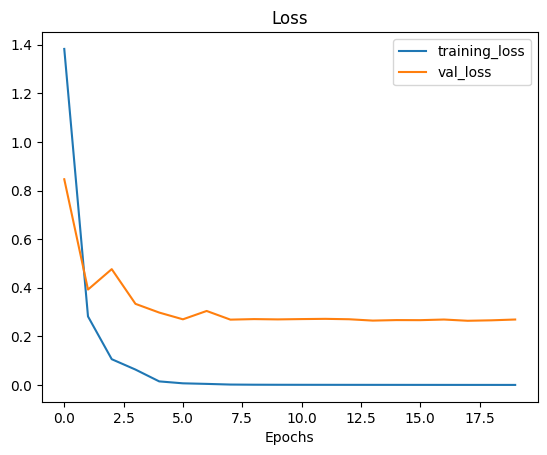

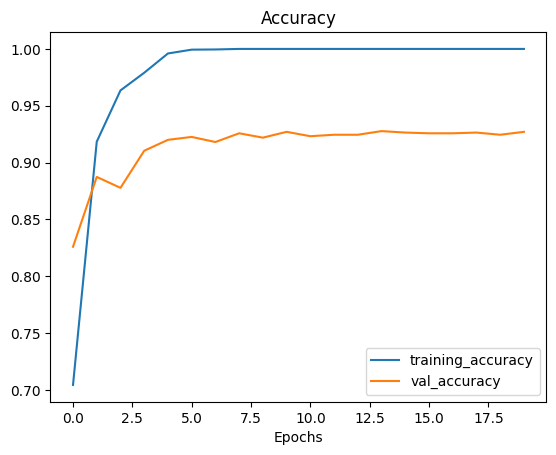

In [ ]:
plot_loss_curves(resnetx3_history)

# Saving the Best Model

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
resnetx3_model = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/resnetx3_model")
resnetx3_model.evaluate(X_test, y_test)

49/49 [==============================] - 18s 168ms/step - loss: 0.2643 - accuracy: 0.9264


[0.26429668068885803, 0.9264235496520996]

In [ ]:
# Saving into h5 format
resnetx3_model.save('/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/satellite_military.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Saving into tf format
resnetx3_model.save('/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/satellite_military.tf')

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/resnetx3_model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/satellite_military_flutter.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Saving into pickle format
import joblib

joblib.dump(resnetx3_model, '/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/satellite_military_flutter.pkl')

['/content/drive/MyDrive/Datasets/Satellite_Millitary/Best Model/satellite_military_flutter.pkl']

# Predict the Image

In [ ]:
n_labels

20

49/49 [==============================] - 8s 143ms/step


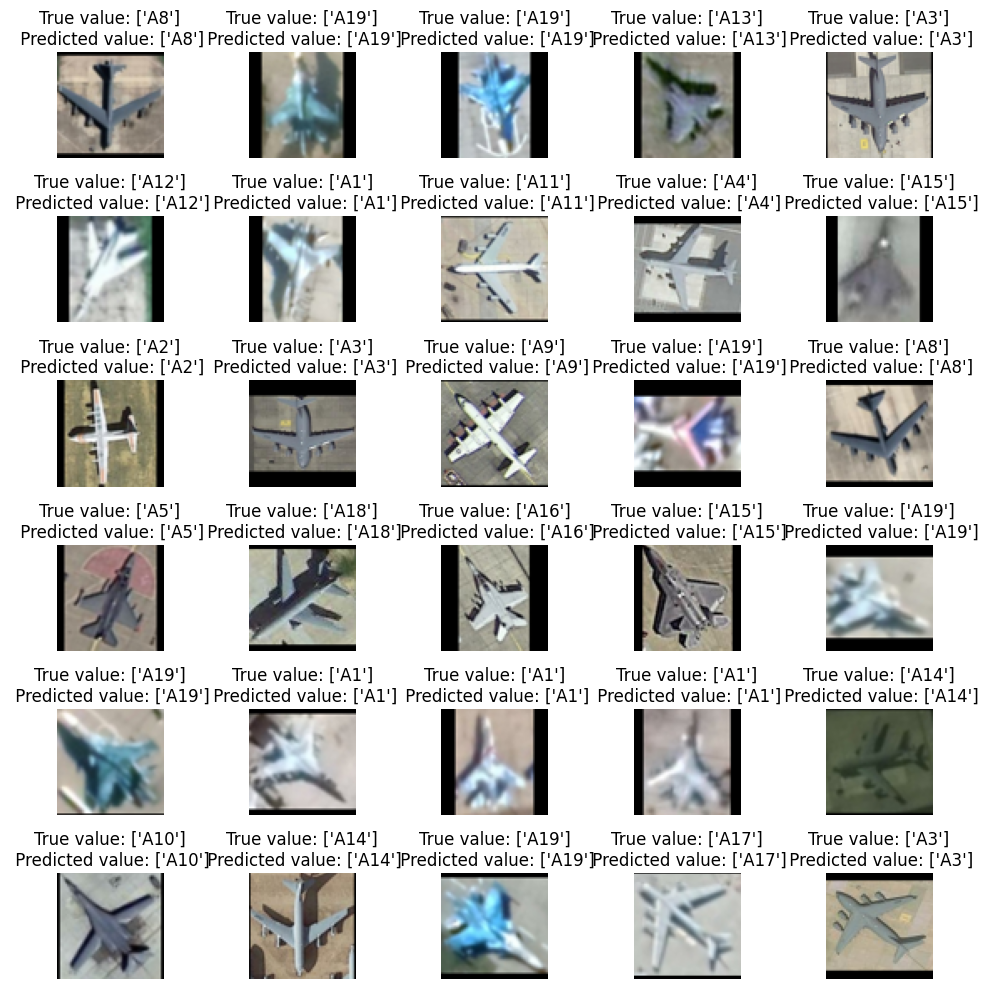

In [ ]:
# Predict
predictions = resnetx3_model.predict(X_test)

# Create a new instance of OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the original categorical labels
encoder.fit(orig_labels)

# Perform the inverse transformation using the OneHotEncoder
y_orig_true = encoder.inverse_transform(y_test)
y_orig_pred = encoder.inverse_transform(predictions)

# Display 16 predictions

# Set up the subplots
fig, axs = plt.subplots(6, 5, figsize=(10, 10))
axs = axs.ravel()

# Generate some random indices
random_numbers = []
for _ in range(30):
    random_number = random.randint(0, X_test.shape[0])
    random_numbers.append(random_number)

for i, rand in enumerate(random_numbers):
    axs[i].imshow(X_test[rand], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"True value: {y_orig_true[rand]}\n Predicted value: {y_orig_pred[rand]}")

plt.tight_layout()
plt.show()

In [ ]:
y_orig_true

array([['A11'],
       ['A1'],
       ['A4'],
       ...,
       ['A9'],
       ['A13'],
       ['A2']], dtype='<U3')

In [ ]:
len(predictions)

1563

In [ ]:
# Get the class predicitons of each label
pred_classes = predictions.argmax(axis=1)

# How do they look?
pred_classes[:30]

array([ 2,  0, 11,  8,  0, 19, 12, 10,  4, 15,  8, 13,  6,  7,  7, 10,  5,
       13,  5,  4,  4,  4, 19, 15,  5,  6,  7,  5, 13,  7])